<a href="https://colab.research.google.com/github/feras-oughali/Notebooks/blob/master/cars_classifier_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Pytorch

In this notebook we try to classify two brands of German cars: `Audi` and `BMW`.
The images are downloaded from `Google Images` and loaded to `Google Drive`.

We'll use transfer learning with Pytorch to customize a pre-trained model to perform the task. 

We cover all the necessary steps needed to achieve the task:
1. Reading the data
2. Splitting the data into training and validation sets
3. Data augmentation
4. Creating the model.
5. Customizing the model. 
6. Training the model
7. Validating the model



## Setup

Mount the drive, setup the path, and imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My\ Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pathlib as Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets, models, transforms
%matplotlib inline


In [3]:
path = Path.Path(root_dir+'cars'); path


PosixPath('/content/gdrive/My\\ Drive/cars')

In [0]:
!ls ./gdrive/My\ Drive/cars

audi  bmw


## Reading the data

Basic transforms: random crop, resize to 224 x 224 as expected by the deployed model later (densenet), and convert image to tensor.

Normalize with the mean and std values of the pre-trained model for the three channels.

In [0]:
train_transforms = transforms.Compose([transforms.Resize(270),
                                       transforms.RandomResizedCrop((224,224)),
                                       transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

Read the data from a rood folder using `torchvision.datasets`, and provide the selected transformations.

In [0]:
data = datasets.ImageFolder(root='./gdrive/My Drive/cars', transform=train_transforms)

In [13]:
data

Dataset ImageFolder
    Number of datapoints: 2699
    Root Location: ./gdrive/My Drive/cars
    Transforms (if any): Compose(
                             Resize(size=270, interpolation=PIL.Image.BILINEAR)
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

We have 2699 images and two classes: `audi` and `bmw`.
Let's visualize one image and see how the transformaitons work. We'll use `matpolotlib` which expects and image to be represented as a `numpy` array. We need to change the order of dimentions as the `imshow` function expects the channels to be last.

In [0]:
img, label = data[0]

In [0]:
img.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


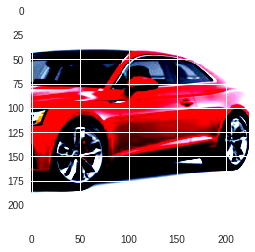

In [0]:
plt.imshow(np.transpose(img, (1, 2, 0)))

## Splitting the data

We need to have a validation set to evaluate our model. A radom split of date will be performed to create the training set and the validation set.

In [0]:
train, test = torch.utils.data.random_split(data, [2000, len(data)-2000])

These datasets are then fed into two dataloaders, which is a convinent way to read a batch of images from the dataset. The `Dataloader` has the option of shuffling the data which is preferred for the training. 

In [0]:
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

In [0]:
len(train_loader), len(test_loaser)

(32, 11)

We'll use transfer learining to build our model. This means that we'll utilize a pre-trained model on `ImageNet` dataset to extract featues from images. However, we neeed to customize the last bit of the model `the classifiers` to map the final outputs into two outputs representing the probabilities of each of the two classes. 

## Build and customize the model

In [0]:
model = models.DenseNet()

In [0]:
model;

the original model has `1000` outputs correspoding to the number of classes in `ImageNet`

In [0]:
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

We'll freeze the parameters for feature extraction and train only the classifier. Note that we can fine-tune these parameters but we'll not consider it for now. 


In [0]:
for param in model.parameters():
  param.requires_grad = False

add the new `classifier`

In [0]:
new_cls = nn.Linear(in_features=1024, out_features=2, bias=True)

In [0]:
model.classifier = new_cls

In [0]:
model;

## Train the model

Define the `optimizer` and the `loss` funciton.

In [0]:
optimizer = optim.SGD(model.classifier.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()

### CPU vs GPU

We can train the model on the `cpu` or the `gpu`. This example show how much time each option takes to process a few batches. Clearly, `gpu` outperforms the `cpu` by a huge gap.

In [0]:
import time
for device in ['cpu', 'cuda']:
    model.to(device)
    for ii, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 7.282 seconds
Device = cuda; Time per batch: 0.014 seconds


Let's grap a batch from the dataloader and check the shapes of the returen tensors.

As we defined earlier the batch size is 64 images each of which is a 3 channels with W x H equals to 224 x 224

We have a tensor of 64 labels which corresponds to the input batch size.

### Verifying the output of the model

In [0]:
inputs, labels = next(iter(train_loader))

In [0]:
inputs.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

the output of the model is of shape 64 x 2 which corresponds to the batch size and the number of classes (2 in this case)

In [0]:
outs = model(inputs.to('cuda'))
outs.shape

torch.Size([64, 2])

In [0]:
outs[0]

tensor([ 1.5453, -1.2036], device='cuda:0', grad_fn=<SelectBackward>)

In order to get the probabilities of each class for each input image, we need to apply a `softmax` function which retures the probabilities of each class. The sum of probabilites for each image must add up to 1.

Below we compute`LogSoftmax` and use `exp` to get the probabilities.

We sum the prbabilites to verify that we get a sum of 1 for each image in the batch.

In [0]:
func = nn.LogSoftmax(dim=1)

In [0]:
logs = func(outs)

In [0]:
ps = torch.exp(logs)

In [0]:
ps.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward2>)

We can use `topk` to obtain the top class and the corresponding index of the label. We can compare the predicted labels and the actual ones and compute the accurary as well. 

We need to be careful with the shapes of the tensors.

In [0]:
top_p, top_class = ps.topk(1, dim=1)

In [0]:
equals = top_class == labels.view(*top_class.shape)

In [0]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 76.5625%


### Training

Here, we train our model for 8 epochs using the `gpu` and we keep track of the training loss and the validation loss. 

In [50]:
epochs = 8
device = 'cuda'
model.to(device)
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outs = model(images)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
      test_loss = 0
      
      with torch.no_grad():
        for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outs = model(images)
          loss = criterion(outs, labels)
          test_loss += loss.item()
          
      test_losses.append(test_loss/len(test_loader))
      train_losses.append(running_loss/len(train_loader))
          
      print("Epoch: {}/{} ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
           "Validation Loss: {:.3f}.. ".format(test_losses[-1]))
    

Epoch: 1/8  Training Loss: 0.655..  Validation Loss: 0.609.. 
Epoch: 2/8  Training Loss: 0.572..  Validation Loss: 0.602.. 
Epoch: 3/8  Training Loss: 0.558..  Validation Loss: 0.584.. 
Epoch: 4/8  Training Loss: 0.548..  Validation Loss: 0.584.. 
Epoch: 5/8  Training Loss: 0.545..  Validation Loss: 0.577.. 
Epoch: 6/8  Training Loss: 0.541..  Validation Loss: 0.578.. 
Epoch: 7/8  Training Loss: 0.537..  Validation Loss: 0.571.. 
Epoch: 8/8  Training Loss: 0.541..  Validation Loss: 0.574.. 


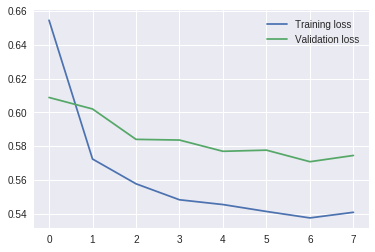

In [51]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

We can track both the training loss and the validation loss to make sure that we are not overfitting to the training data. 

We can also track metrics about the model, like the accuracy of prediciton for example.

## Saving and Loading the model

In [57]:

print("Sample of the state dict keys of the model: \n", list(model.state_dict().keys())[:5])

Sample of the state dict keys of the model: 
 ['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var']


In [0]:
torch.save(model.state_dict(), 'model_state.pth')

In [0]:
state_dict = torch.load('model_state.pth')

In [0]:
model.load_state_dict(state_dict)
